<left>
<img src="idc_logo.png" width=100 align="left">
</left>

<H4>Advanced Stats. for Data Science (Spring 2022)</H4>

<H1>Examples from Lecture 8 </H1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import scipy
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size': 18})
%matplotlib inline
sns.set_style("white")

# ANOVA

Using the Wine Review Kaggle dataset https://www.kaggle.com/datasets/zynicide/wine-reviews

In [2]:
wine_df = pd.read_csv("winemag-data_first150k.csv")
lo_countries = ['Israel', 'Canada', 'India', 'Croatia', 'Hungary']
variable = 'points'

          Unnamed: 0       points        price     logPrice
count    1154.000000  1154.000000  1125.000000  1125.000000
mean    69120.781629    87.321490    33.786667     3.297199
std     42344.177758     2.701342    35.399459     0.618439
min        81.000000    80.000000     7.000000     1.945910
25%     31687.750000    85.000000    17.000000     2.833213
50%     68189.000000    87.000000    25.000000     3.218876
75%    102913.000000    89.000000    40.000000     3.688879
max    150727.000000    96.000000   764.000000     6.638568


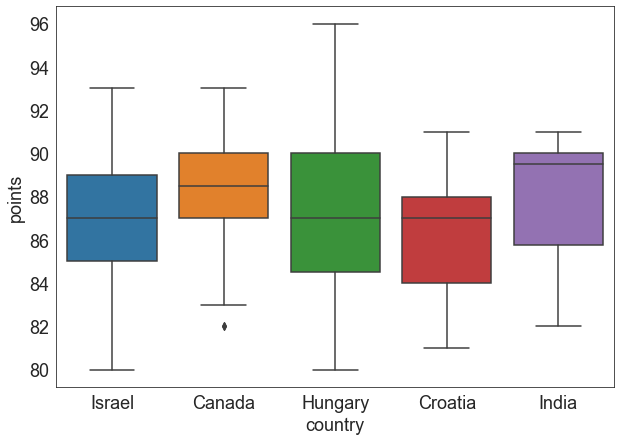

In [3]:
wine_df = wine_df[wine_df.country.isin(lo_countries)]
wine_df['logPrice'] = np.log(wine_df.price)
print(wine_df.describe())

sns.boxplot(x='country', y='points', data=wine_df); plt.show()

Question
- Q: do some countries produce better wine?

$$
H_0~:~\text{quality is unaffected by country}
$$
(flactuations are due to chance)

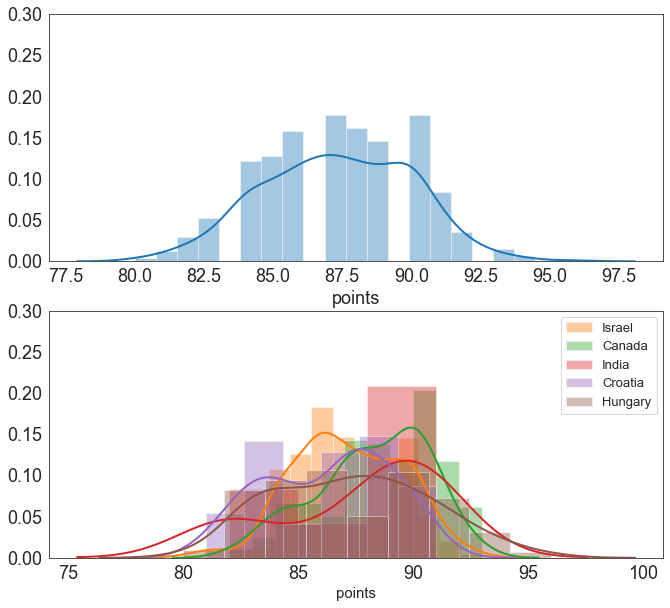

In [4]:
colors = sns.color_palette()
plt.figure(figsize=(11, 10))
plt.xlim(0, 8)
plt.subplot(211)
sns.distplot(wine_df[variable], kde_kws=dict(linewidth=2))
plt.ylim(0, .3)

plt.subplot(212)
plt.ylim(0, .3)
for i,name in enumerate(lo_countries):
    sns.distplot(wine_df[wine_df.country==name][variable], kde_kws=dict(linewidth=2), color=colors[i+1])
    

plt.legend(lo_countries, fontsize=13)
plt.xlabel(variable, fontsize=15)
plt.ylim(0, .3)
plt.show()


In [5]:
def ssquares(x):
    return np.sum((x - np.mean(x)) ** 2)

ss_wit = wine_df.groupby('country')[variable].agg(ssquares).sum()
ss_tot = np.sum((wine_df[variable] -  wine_df[variable].mean()) ** 2)

n = len(wine_df)
k = len(lo_countries)

ss_bet = ss_tot - ss_wit

MSE_bet = ss_bet / (k-1)
MSE_wit = ss_wit / (n-k)

F = MSE_bet / MSE_wit
print(f"F = {F}")
print(f"Pvalue = {scipy.stats.f.sf(F, k-1, n-k)}")


F = 9.731685808221775
Pvalue = 9.647683998909984e-08


### We can also do ANOVA using a statistical package:

In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA Test 
model = ols('points ~ country', data=wine_df).fit()
anova = sm.stats.anova_lm(model, typ=2)
anova

,sum_sq,df,F,PR(>F)
country,275.706388,4.0,9.731686,9.647684e-08
Residual,8138.020648,1149.0,NaN,NaN


## Multiple Testing

In [7]:
def two_smp_t(smp1, smp2):
    return scipy.stats.ttest_ind(smp1, smp2).pvalue

tests_res = {}
for ct1 in lo_countries:
    for ct2 in lo_countries:
        if ct1 < ct2:
            smp1 = wine_df[wine_df.country == ct1][variable].values
            smp2 = wine_df[wine_df.country == ct2][variable].values
            tests_res[(ct1, ct2)] = two_smp_t(smp1, smp2)
tests_res

{('Canada', 'Israel'): 7.967154132763609e-08,
 ('Canada', 'India'): 0.4993789484200478,
 ('Canada', 'Croatia'): 4.56744904280583e-09,
 ('Canada', 'Hungary'): 0.0019696912553598123,
 ('India', 'Israel'): 0.5989477239002043,
 ('Croatia', 'Israel'): 0.0011239137221168342,
 ('Croatia', 'India'): 0.1896534525884444,
 ('Croatia', 'Hungary'): 0.00948620314728295,
 ('Hungary', 'Israel'): 0.46083155157006417,
 ('Hungary', 'India'): 0.809646813572837}

In [8]:
pv = list(tests_res.values())
m = len(pv)

idcs = np.argsort(pv)
sorted_pvals = np.array(pv)[idcs]

## Bonferroni:

Reject whatever is below $\alpha/m$

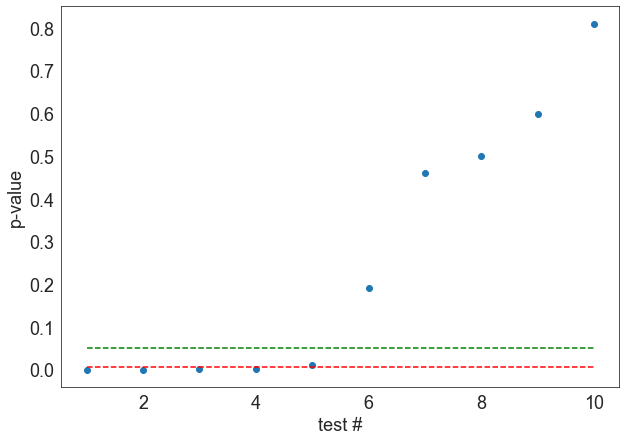

Discovered by Bonferroni:


[('Canada', 'Croatia'),
 ('Canada', 'Israel'),
 ('Croatia', 'Israel'),
 ('Canada', 'Hungary')]

In [9]:

plt.scatter(np.arange(1,len(pv)+1), sorted_pvals)

# Discoveries by Bonferroni's:
alpha = 0.05
plt.plot([1, m], [alpha / m, alpha / m], '--r')
plt.plot([1, m], [alpha, alpha], '--g')
plt.ylabel('p-value')
plt.xlabel('test #')
plt.savefig("Bonf.png")
plt.show()

# Discoveries by BH:
rejected = sorted_pvals * len(sorted_pvals) < .05

print("Discovered by Bonferroni:")
[list(tests_res.keys())[i] for i in idcs[rejected]]

# Binjamini and Hochberg 
Reject all $p_{(i)} \leq q \cdot i/m$

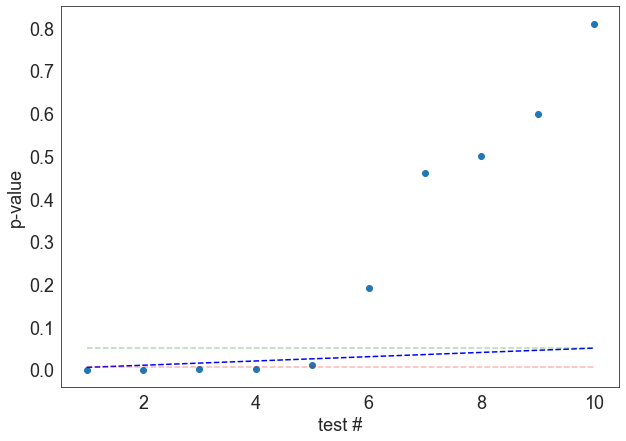

Discovered by BH:


[('Canada', 'Croatia'),
 ('Canada', 'Israel'),
 ('Croatia', 'Israel'),
 ('Canada', 'Hungary'),
 ('Croatia', 'Hungary')]

In [10]:

plt.scatter(np.arange(1,len(pv)+1), sorted_pvals)

# Discoveries by Bonferroni's:
q = 0.05
ell = np.arange(1,m+1) / m * q

plt.plot(np.arange(1,m+1), ell, '--b')

plt.plot([1, m], [alpha / m, alpha / m], '--r', alpha=.3)
plt.plot([1, m], [alpha, alpha], '--g',  alpha=.3)

plt.ylabel('p-value')
plt.xlabel('test #')
plt.show()

# Discoveries by BH:
rejected = sorted_pvals < ell

print("Discovered by BH:")
[list(tests_res.keys())[i] for i in idcs[rejected]]

## Without assuming independence or PRD

In [1]:

plt.scatter(np.arange(1,len(pv)+1), sorted_pvals)

# Discoveries by Bonferroni's:
q = 0.05
ell = np.arange(1,m+1) / m * q
ell_dep = np.arange(1,m+1) / m * q / (np.log(m))

plt.plot([1, m], [alpha / m, alpha / m], '--r', alpha=.3)
plt.plot([1, m], [alpha, alpha], '--g',  alpha=.3)

plt.plot(np.arange(1,m+1), ell, '--b', alpha = .3)

plt.plot(np.arange(1,m+1), ell_dep, '--m')

plt.ylabel('p-value')
plt.xlabel('test #')
plt.savefig('BH_sm_dep.png')
plt.show()


rejected = sorted_pvals < ell_dep

print("Discovered by BH w/o independence assumption:")
[list(tests_res.keys())[i] for i in idcs[rejected]]



NameError: name 'plt' is not defined

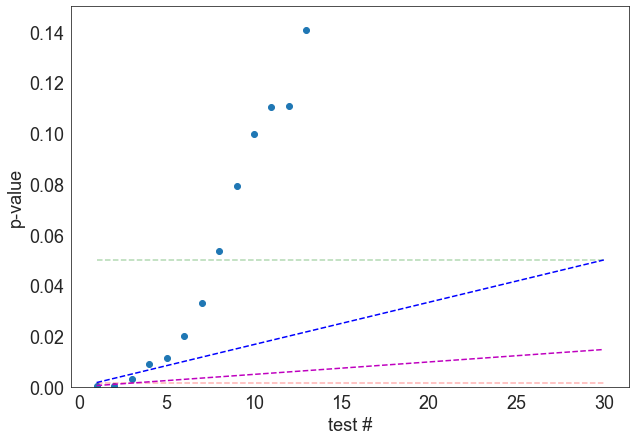

In [13]:
m = 30
z = np.random.randn(m)
z[0:10] += 2

pvals = np.sort(scipy.stats.norm.sf(np.abs(z)))


m = len(pvals)

plt.scatter(np.arange(1,len(pvals)+1), pvals)
plt.ylabel('p-value')
plt.xlabel('test #')
# Discoveries by Bonferroni's:
q = 0.05
ell = np.arange(1,m+1) / m * q
ell_dep = np.arange(1,m+1) / m * q / (np.log(m))

plt.plot([1, m], [alpha / m, alpha / m], '--r', alpha=.3)
plt.plot([1, m], [alpha, alpha], '--g',  alpha=.3)

plt.plot(np.arange(1,m+1), ell, '--b')
plt.plot(np.arange(1,m+1), ell_dep, '--m')
plt.ylim([0, .15])
plt.savefig("BH_all.png")


plt.show()

# Regression

In [14]:
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt

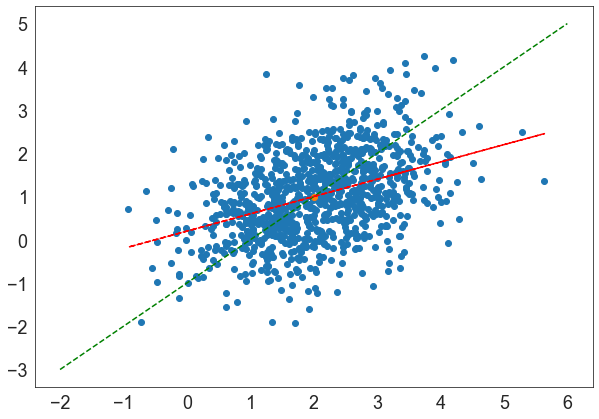

In [15]:
rho = .4
sigX = 1
sigY = 1

mu_X = 2
mu_Y = 1

n = 1000

z = norm.rvs(size=(n, 2)).T
Sig = np.array([[sigX ** 2, sigX * sigY * rho],
                [sigX * sigY * rho, sigY ** 2]])
Sig_sqrt = np.linalg.cholesky(Sig)
x, y = np.array([[mu_X, mu_Y]]).T + Sig_sqrt @ z

plt.scatter(x, y)
plt.scatter(mu_X, mu_Y)
plt.plot([mu_X - 4, mu_X+4], [mu_Y-4, mu_Y+4], '--g')  # "45deg line"

y_reg = mu_Y + rho*sigY/sigX * (x - mu_X) # regression line
plt.plot(x, y_reg, '--r')
plt.savefig("regression.png")
plt.show()

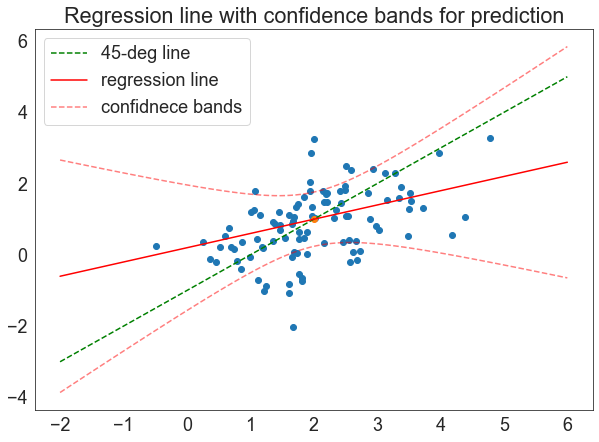

In [29]:
from scipy.stats import t

rho = .4
sigX = 1
sigY = 1

mu_X = 2
mu_Y = 1

n = 100

z = norm.rvs(size=(n, 2)).T
Sig = np.array([[sigX ** 2, sigX * sigY * rho],
                [sigX * sigY * rho, sigY ** 2]])
Sig_sqrt = np.linalg.cholesky(Sig)
x, y = np.array([[mu_X, mu_Y]]).T + Sig_sqrt @ z

plt.scatter(x, y)
plt.scatter(mu_X, mu_Y)
plt.plot([mu_X - 4, mu_X+4], [mu_Y-4, mu_Y+4], '--g')  # "45deg line"


xx = np.linspace(-2, 6, 100)
y_reg = mu_Y + rho*sigY/sigX * (xx - mu_X) # regression line

plt.plot(xx, y_reg, 'r')

t_alpha = t.isf(.05 / 2, df = n-2)

s2 = np.linalg.norm(y - y_reg)/(n-2)
Sxx = np.mean((x - np.mean(x))**2)



y_reg2 = mu_Y + rho*sigY/sigX * (xx - mu_X) # regression line
y_band = t_alpha * np.sqrt(s2) * np.sqrt(1 + 1/n + (xx - np.mean(x))**2/Sxx )

plt.plot(xx, y_reg2 + y_band, '--r', alpha=.5)
plt.plot(xx, y_reg2 - y_band, '--r', alpha=.5)

plt.title("Regression line with confidence bands for prediction")
plt.legend(['45-deg line', 'regression line', 'confidnece bands'])
plt.savefig("regression_band.png")
plt.show()